In [1]:
#!pip install gensim
#https://radimrehurek.com/gensim/models/keyedvectors.html
#nltk.download('punkt')

In [2]:
#!pip install html2text
#!python -m spacy link en_core_web_md en_default

In [3]:
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
import time
import spacy
import re
import nltk
import timeit
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

df_train = pd.read_csv('share_repurchase_paragraphs.csv')
df_train = df_train.apply(lambda x: x.astype(str).str.lower())

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Next Steps: Considering skipping everything before Item 8

In [100]:
friendly_lists = {}

friendly_lists.update({'share_repurchase_auth' : ['board of director', 'of directors authoriz', 'of up to', 'our board of', 'the repurchase of', "'s board of",
'share repurchase program', 'the board of', 'of directors approv', 'authorized the repurchase',
"company 's board", 'directors authorized a', 'repurchase up to', 'repurchase of up']})

friendly_lists.update({'Unknown_Share_Repurchase_Data' : ['board of director', 'of directors authoriz', 'of up to', "'s board of", 'authorized the repurchase',
'the repurchase of', 'the board of', 'directors authorized the', "company 's board",'repurchase up to', 'our board of', 'repurchase of up', 'to repurchase up', 'share repurchase program']})

friendly_lists.update({'Share_Repurchase_Intention' : ['board of directors', 'share repurchase program', 'stock repurchase program',
'remained available for', 'our board of', 'repurchase up to', 'share repurchase authorization',
'available under the', 'to repurchase up', 'repurchase under the', 'under the program']})

friendly_lists.update({'Share_Repurchase_Utilization' : ['a total of', 'for a total', 'a total cost', 'total cost of', 'aggregate cost of', 
'company had repurchased', 'repurchased a total', 'as of december', 'of december 31']})

friendly_lists.update({'Amount_Spent_on_Share_Repurchases' : ['a cost of', 'total cost of', 'at a cost', 'of common stock', 'a total cost', 'aggregate cost of',
'for a total', 'at a total', 'a total of', 'cost of shares', 'of shares repurchased', 'at an aggregate', 'an aggregate cost',
'in millions', 'repurchase of common']})

friendly_lists.update({'Share_Repurchase_Count' : ['a cost of', 'total cost of', 'at a cost', 'of common stock', 'a total cost',
'aggregate cost of', 'for a total', 'at a total', 'a total of', 'cost of shares', 'of shares repurchased', 
'at an aggregate', 'an aggregate cost', 'in millions', 'repurchase of common', 'aggregate purchase price', 'cost of repurchase']})

In [101]:
start = time.time()
path = "data/nc_validation_filings/"
file_pattern = r"[\d-]+"
compiled_df = pd.DataFrame(columns=['friendly name','accession number','sentence'])  # creating blank df with named columns

acc = []
sent = []                               # creating empty lists to append in loop
friendly_name = []


for filename in os.listdir(path):
     if filename.endswith('.html'):
        fname = os.path.join(path,filename)
        accession = re.findall(file_pattern, fname)
        with open(fname, 'r', encoding="utf8") as f:
            soup = BeautifulSoup(f.read(),'html.parser')
            soup.head.extract()
            soup = soup.get_text().strip()
            sentences = nltk.sent_tokenize(soup)     #tokenized sentences
            for cats,values in friendly_lists.items():
                for ngram in values:
                    for sentence in sentences:
                        if ngram in sentence:
                            sent.append(sentence)
                            friendly_name.append(cats)
                            acc.append(accession[0])

compiled_df = compiled_df.append(pd.DataFrame({'friendly name':friendly_name, 'accession number':acc, 'sentence':sent}), ignore_index=True)

compiled_df['sentence'] = compiled_df['sentence'].str.lower()
compiled_df.drop_duplicates(keep='first', inplace=True)
compiled_df = compiled_df.reset_index()

# stripping out unicode characters created from new line, other doc strings, and extra spaces#
compiled_df['sentence'] = compiled_df['sentence'].str.replace(u'\n',' ')
compiled_df['sentence'] = compiled_df['sentence'].str.replace(u'\ufeff',' ')
compiled_df['sentence'] = compiled_df['sentence'].str.replace('  ',' ')
compiled_df['sentence'] = compiled_df['sentence'].str.replace('  ',' ')
compiled_df['sentence'] = compiled_df['sentence'].str.replace('  ',' ')

end = time.time()
print(end-start)

233.9132046699524


In [86]:
compiled_df['friendly name'].value_counts()

share_repurchase_auth                4387
Share_Repurchase_Count               2718
Amount_Spent_on_Share_Repurchases    2631
Unknown_Share_Repurchase_Data        1258
Share_Repurchase_Intention           1029
Share_Repurchase_Utilization          374
Name: friendly name, dtype: int64

In [83]:
compiled_df_backup = compiled_df

In [102]:
new_df = compiled_df[(compiled_df['friendly name'] == 'Amount_Spent_on_Share_Repurchases') & compiled_df['sentence'].str.contains('repurchase')]
new_df2 = count_repurchase = compiled_df[(compiled_df['friendly name'] == 'Share_Repurchase_Count') & compiled_df['sentence'].str.contains('repurchase')]

In [103]:
compiled_df = compiled_df[compiled_df['friendly name'] != 'Share_Repurchase_Count']
compiled_df = compiled_df[compiled_df['friendly name'] != 'Amount_Spent_on_Share_Repurchases']

In [104]:
final_df = pd.concat([compiled_df, new_df, new_df2])

In [105]:
final_df['friendly name'].value_counts()

share_repurchase_auth                1258
Unknown_Share_Repurchase_Data        1258
Share_Repurchase_Intention           1029
Share_Repurchase_Utilization          374
Share_Repurchase_Count                287
Amount_Spent_on_Share_Repurchases     271
Name: friendly name, dtype: int64

In [106]:
final_df.to_csv('final_submission.csv')

In [8]:
------------------------------------
 intentional fault to stop full run
------------------------------------

SyntaxError: invalid syntax (<ipython-input-8-ebdd3a797a3a>, line 1)

In [ ]:
#nltk.Text(soup).concordance("December")

In [ ]:
#compiled_df.to_csv('two_files_process.csv')

# attempting word2vec

In [50]:
toked_sent = compiled_df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [46]:
# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
model = Word2Vec(toked_sent, workers=8, window=15)
words = list(model.wv.vocab)

In [47]:
model.train(toked_sent, total_examples=len(toked_sent), epochs=10)

(931478, 1745200)

In [48]:
w1 = 'authorized'
model.wv.most_similar(positive=w1)

[('approved', 0.7679278254508972),
 ('500', 0.5650625228881836),
 ('3.0', 0.5228039026260376),
 ('program', 0.49230027198791504),
 ('40.0', 0.4908383786678314),
 ('new', 0.4880712330341339),
 ('8.0', 0.48074162006378174),
 ('12-month', 0.4538639187812805),
 ('5.0', 0.450647234916687),
 ('authorization', 0.45008155703544617)]

In [49]:
w2 = 'repurchased'
model.wv.most_similar(positive=w2)

[('3.7', 0.5970293283462524),
 ('cost', 0.588647186756134),
 ('retired', 0.5762770175933838),
 ('approximately', 0.5637603402137756),
 ('million', 0.5474063158035278),
 ('5.2', 0.5417565107345581),
 ('weighted', 0.5204445123672485),
 ('aag', 0.48633620142936707),
 ('total', 0.4820529818534851),
 ('3.4', 0.4789106845855713)]

In [14]:
w3 = 'shares'
model.wv.most_similar(positive=w3)

[('20.35', 0.4950753152370453),
 ('4.2', 0.46257972717285156),
 ('1,399', 0.4528132379055023),
 ('approximately', 0.4512806534767151),
 ('million', 0.4408422112464905),
 ('5.2', 0.43424999713897705),
 ('11.9', 0.4294128119945526),
 ('occidental', 0.4234777092933655),
 ('inception', 0.4150186777114868),
 ('400,017', 0.4122242331504822)]

In [15]:
model.wv.similarity(w1,w3)

0.10280463866179755

In [16]:
model.wv.similarity(w1,w2)

-0.036174253042400475

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


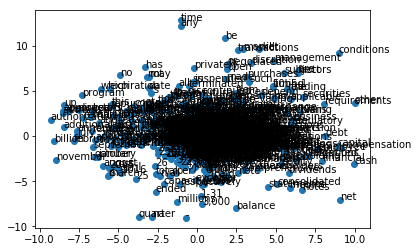

In [44]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)

for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.figure(figsize=(15,15))
pyplot.show()


In [18]:
print(model)

Word2Vec(vocab=1459, size=100, alpha=0.025)


In [ ]:
------------------------------------
 intentional fault to stop full run
------------------------------------

## old code below to keep for testing

In [ ]:
# working --- keeping as backup #
start = time.time()

path = "data/nc_validation_filings_test"
file_pattern = r"[\d-]+"

for filename in os.listdir(path):
     if filename.endswith('.html'):
        fname = os.path.join(path,filename)
        with open(fname, 'r', encoding="utf8") as f:
            soup = BeautifulSoup(f.read(),'html.parser')
            soup.head.extract()
            soup = soup.get_text().strip()
            sentences = nltk.sent_tokenize(soup)
# creating df of sentences matched to accession numbers. Making sure the two lists are the same size before appending to df
            value = [sentence for sentence in sentences if "repurchase" in sentence]
            key = re.findall(file_pattern, fname) 
            compiled_df = compiled_df.append(pd.DataFrame({'acc': key, 'text': value}), ignore_index=True)

compiled_df['text'] = compiled_df['text'].str.lower()

# stripping out unicode characters created from new line, other doc strings, and extra spaces#
compiled_df['text'] = compiled_df['text'].str.replace(u'\n',' ')
compiled_df['text'] = compiled_df['text'].str.replace(u'\ufeff',' ')
compiled_df['text'] = compiled_df['text'].str.replace('  ',' ')
compiled_df['text'] = compiled_df['text'].str.replace('  ',' ')
compiled_df['text'] = compiled_df['text'].str.replace('  ',' ')

end = time.time()
print(end-start)
compiled_df

In [ ]:
compiled_df.head()

In [ ]:
# generator didn't work....
'''start = time.time()

path = "data/nc_validation_filings_test"
file_pattern = r"[\d-]+"
guess_list = ['board of directors','shares']

for filename in os.listdir(path):
     if filename.endswith('.html'):
        fname = os.path.join(path,filename)
        with open(fname, 'r', encoding="utf8") as f:
            soup = BeautifulSoup(f.read(),'html.parser')
            soup.head.extract()
            soup = soup.get_text().strip()
            sentences = nltk.sent_tokenize(soup)
# creating df of sentences matched to accession numbers. Making sure the two lists are the same size before appending to df
            value = [x for x in sentences if x in guess_list in sentence]
#            value = [guess for guess in sentences if guess_list in guess]    
            key = re.findall(file_pattern, fname) * len(value)
            compiled_df = compiled_df.append(pd.DataFrame({'acc': key, 'text': value}), ignore_index=True)

compiled_df['text'] = compiled_df['text'].str.lower()

end = time.time()
print(end-start)'''

In [ ]:
##########################################
#    pasting for reference purposes     #
########################################

# https://spacy.io/usage/training#ner
#!/usr/bin/env python
# coding: utf8
"""Example of training spaCy's named entity recognizer, starting off with an
existing model or a blank model.

For more details, see the documentation:
* Training: https://spacy.io/usage/training
* NER: https://spacy.io/usage/linguistic-features#named-entities

Compatible with: spaCy v2.0.0+
"""

from __future__ import unicode_literals, print_function

import plac
import random
from pathlib import Path
import spacy


# training data
TRAIN_DATA = [
    ('Who is Shaka Khan?', {
        'entities': [(7, 17, 'PERSON')]
    }),
    ('I like London and Berlin.', {
        'entities': [(7, 13, 'LOC'), (18, 24, 'LOC')]
    })
]


@plac.annotations(
    model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
    output_dir=("Optional output directory", "option", "o", Path),
    n_iter=("Number of training iterations", "option", "n", int))
def main(model=None, output_dir=None, n_iter=100):
    """Load the model, set up the pipeline and train the entity recognizer."""
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")

    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe('ner')

    # add labels
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)
            print(losses)

    # test the trained model
    for text, _ in TRAIN_DATA:
        doc = nlp(text)
        print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
        print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        for text, _ in TRAIN_DATA:
            doc = nlp2(text)
            print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
            print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])


#if __name__ == '__main__':
#    plac.call(main)

    # Expected output:
    # Entities [('Shaka Khan', 'PERSON')]
    # Tokens [('Who', '', 2), ('is', '', 2), ('Shaka', 'PERSON', 3),
    # ('Khan', 'PERSON', 1), ('?', '', 2)]
    # Entities [('London', 'LOC'), ('Berlin', 'LOC')]
    # Tokens [('I', '', 2), ('like', '', 2), ('London', 'LOC', 3),
    # ('and', '', 2), ('Berlin', 'LOC', 3), ('.', '', 2)]

In [ ]:
#df_train['paragraph_text'][1]

In [ ]:
#df_train[df_train['ticker'] == 'aapl']

In [ ]:
#df_train.data_key_friendly_name.value_counts()

In [ ]:
#df_train[df_train["data_key_friendly_name"] == 'share repurchase authorization']

In [ ]:
#df_train[df_train["data_key_friendly_name"] == 'share repurchase authorization'].text.unique()

In [ ]:
nlp = spacy.load('en')
doc = nlp(soup)

# Print all of the found entities and their labels
for ent in doc.ents:
    print(ent.label_, ent.text)


In [ ]:
df = pd.read_html(str(table), header=0)[0]

In [ ]:
text = soup.strip(' \t\n\r')
text = text.strip()

In [ ]:
text

In [ ]:
'''doc = nlp(soup)

# Print all of the found entities and their labels
for ent in doc.ents:
    print(ent.label_, ent.text)
'''

In [ ]:
import html2text

path = "data/nc_validation_filings_test/"
file = "0000007332-18-000016.html"
html = open(path+file, encoding="utf8").read()
#print html2text.html2text(html)